In [1]:
# Configuration Block - EDIT ONLY THIS SECTION if your columns/paths differ

CONFIG = {
    "paths": {
        "base": None,
        "files": {

            "PBCD_G": "PBCD_G.xpt",
            "PBCD_H": "PBCD_H.xpt",
            "PBCD_I": "PBCD_I.xpt",
            "PFQ_G": "PFQ_G.xpt",
            "PFQ_H": "PFQ_H.xpt",
            "PFQ_I": "PFQ_I.xpt",
            "DEMO_G": "DEMO_G.xpt",
            "DEMO_H": "DEMO_H.xpt",
            "DEMO_I": "DEMO_I.xpt",
            "BMX_G": "BMX_G.xpt",
            "BMX_H": "BMX_H.xpt",
            "BMX_I": "BMX_I.xpt",
        }
    },
    "columns": {
        "outcome": "any_disability",
        "blood_metals": {
            "lead":    "LBXBPB",  # blood lead (µg/dL)
            "cadmium": "LBXBCD",  # blood cadmium (µg/L)
            "mercury": "LBXTHG",  # blood total mercury (µg/L)
            "selenium": "LBXBSE", # blood selenium (µg/L)
            "manganese": "LBXBMN", # blood manganese (µg/L)
        },
        "covariates": {
            "age":  "RIDAGEYR",
            "sex":  "RIAGENDR",
            "race": "RIDRETH1",
            "bmi":  "BMXBMI",
        },
        "weight_2yr": "WTMEC2YR",
        "weight_6yr": "WTMEC6YR",
    },
    "outdir": "results_comprehensive",
    "seed": 42,
}





In [2]:
# Imports & Helper Functions

import os, sys, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, brier_score_loss, classification_report
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Suppress warnings
warnings.filterwarnings("ignore")
np.random.seed(CONFIG["seed"])

# Import XGBoost if available
try:
    import xgboost as xgb
    XGB_AVAILABLE = True

except ImportError:
    XGB_AVAILABLE = False


# Helper functions
def ensure_dir(path):
    """Create directory if it doesn't exist"""
    os.makedirs(path, exist_ok=True)

def log1p_safe(s: pd.Series) -> pd.Series:
    """Safe log1p transformation handling negative values"""
    s = s.astype(float)
    m = s.min(skipna=True)
    if pd.notna(m) and m < 0:
        s = s - m  # Shift to make all values non-negative
    return np.log1p(s)

def weighted_auc(y_true, y_prob, sample_weight=None):
    """Calculate weighted AUC"""
    return roc_auc_score(y_true, y_prob, sample_weight=sample_weight)

def youden_threshold(y_true, y_prob, sample_weight=None):
    """Find optimal threshold using Youden's J statistic"""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob, sample_weight=sample_weight)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_sensitivity = tpr[optimal_idx]
    optimal_specificity = 1 - fpr[optimal_idx]
    return float(optimal_threshold), float(optimal_sensitivity), float(optimal_specificity)

def weighted_confusion_matrix(y_true, y_prob, threshold=0.5, sample_weight=None):
    """Calculate weighted confusion matrix metrics"""
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, sample_weight=sample_weight).ravel()

    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else np.nan

    return {
        'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn,
        'sensitivity': sensitivity, 'specificity': specificity, 'accuracy': accuracy
    }




In [3]:
# Use existing merged_df and build comprehensive disability outcome

# Use existing merged_df

# Load and merge NHANES data files based on CONFIG
nhanes_data = {}
base_path = CONFIG["paths"]["base"] if CONFIG["paths"]["base"] else "./" # Use current directory if base is None

print("Loading NHANES data files...")
for key, filename in CONFIG["paths"]["files"].items():
    file_path = os.path.join(base_path, filename)
    if os.path.exists(file_path):
        try:
            nhanes_data[key] = pd.read_sas(file_path)
            print(f"  Loaded {filename} ({nhanes_data[key].shape[0]:,} rows)")
        except Exception as e:
            print(f"  Error loading {filename}: {e}")
    else:
        print(f"  File not found: {file_path}")

# Merge dataframes on 'SEQN' (Respondent Sequence Number)
if nhanes_data:
    # Start with the first dataframe
    first_key = list(nhanes_data.keys())[0]
    merged_df = nhanes_data[first_key].copy()
    print(f"\n Starting merge with {first_key} ({merged_df.shape})")

    # Merge the rest
    for key, df in list(nhanes_data.items())[1:]:
        if 'SEQN' in df.columns:
            initial_rows = merged_df.shape[0]
            merged_df = pd.merge(merged_df, df, on='SEQN', how='left', suffixes=('', f'_{key}'))
            print(f"  Merged {key} ({df.shape}) -> {merged_df.shape} (added {merged_df.shape[0] - initial_rows} rows, expected 0)")
        else:
            print(f"  Skipping merge for {key}: missing 'SEQN' column")

else:
    merged_df = pd.DataFrame()
    print("\n No data files loaded, merged_df is empty.")


print(f"\n Working with existing merged_df: {merged_df.shape}")
print(f" Available PFQ columns: {[col for col in merged_df.columns if col.startswith('PFQ')]}")

# Create comprehensive disability outcome using multiple PFQ items
def create_disability_outcome(df):
    """Analysis function"""
    df = df.copy()

    # PFQ items (1=Yes difficulty, 2=No difficulty, 7=Refused, 9=Don't know)
    pfq_items = {
        'PFQ049': 'Walking 1/4 mile',
        'PFQ051': 'Walking up stairs',
        'PFQ054': 'Stooping/crouching',
        'PFQ057': 'Standing up from chair',
        'PFQ059': 'Standing for periods',
    }

    available_items = {k: v for k, v in pfq_items.items() if k in df.columns}


    if not available_items:
        print("  No PFQ columns found for disability outcome creation.")
        # Check if a 'disability_status' column already exists
        if 'disability_status' in df.columns:
             print("  Using existing 'disability_status' column.")
             df[CONFIG['columns']['outcome']] = df['disability_status']
             return df
        else:
            print("  No existing 'disability_status' column found. Cannot create outcome.")
            return df # Return df without the outcome column

    # Create binary indicators for each PFQ item (1 = has difficulty)
    disability_indicators = []
    for item, description in available_items.items():
        df[f'{item}_disability'] = (df[item] == 1).astype(int)
        disability_indicators.append(f'{item}_disability')
        print(f"   {item}: {description} - {df[f'{item}_disability'].sum():,} with difficulty")

    # Create comprehensive disability outcome
    # Person has disability if they report difficulty with ANY of the activities
    df[CONFIG['columns']['outcome']] = (df[disability_indicators].sum(axis=1) >= 1).astype(int)

    return df

# Apply disability outcome creation
work_df = create_disability_outcome(merged_df)

# Display outcome distribution
outcome_col = CONFIG['columns']['outcome']
if outcome_col in work_df.columns:
    outcome_dist = work_df[outcome_col].value_counts()
    outcome_pct = work_df[outcome_col].value_counts(normalize=True) * 100

    print(f"\n {outcome_col} Distribution:")
    print(f"   No disability (0): {outcome_dist.get(0, 0):,} ({outcome_pct.get(0, 0):.1f}%)")
    print(f"   Has disability (1): {outcome_dist.get(1, 0):,} ({outcome_pct.get(1, 0):.1f}%)")
else:
    print(f"  Outcome column '{outcome_col}' not created. Check data loading and PFQ columns.")
    # This case should ideally not happen if PFQ data is loaded correctly, but as a fallback:
    # If no PFQ data and no existing 'disability_status', the outcome won't exist.
    pass # No action needed, the message above indicates the issue.

Loading NHANES data files...
  Loaded PBCD_G.xpt (8,956 rows)
  Loaded PBCD_H.xpt (5,932 rows)
  Loaded PBCD_I.xpt (5,815 rows)
  Loaded PFQ_G.xpt (8,350 rows)
  Loaded PFQ_H.xpt (9,230 rows)
  Loaded PFQ_I.xpt (8,991 rows)
  Loaded DEMO_G.xpt (9,756 rows)
  Loaded DEMO_H.xpt (10,175 rows)
  Loaded DEMO_I.xpt (9,971 rows)
  Loaded BMX_G.xpt (9,338 rows)
  Loaded BMX_H.xpt (9,813 rows)
  Loaded BMX_I.xpt (9,544 rows)

 Starting merge with PBCD_G ((8956, 16))
  Merged PBCD_H ((5932, 17)) -> (8956, 32) (added 0 rows, expected 0)
  Merged PBCD_I ((5815, 17)) -> (8956, 48) (added 0 rows, expected 0)
  Merged PFQ_G ((8350, 35)) -> (8956, 82) (added 0 rows, expected 0)
  Merged PFQ_H ((9230, 36)) -> (8956, 117) (added 0 rows, expected 0)
  Merged PFQ_I ((8991, 36)) -> (8956, 152) (added 0 rows, expected 0)
  Merged DEMO_G ((9756, 48)) -> (8956, 199) (added 0 rows, expected 0)
  Merged DEMO_H ((10175, 47)) -> (8956, 245) (added 0 rows, expected 0)
  Merged DEMO_I ((9971, 47)) -> (8956, 291) (a

In [4]:
# Feature Engineering: Metals log transforms, quartiles, covariates, and weights

C = CONFIG["columns"]
outcome_col = C["outcome"]

# Get blood metal columns that exist in our data
blood_metals = list(C["blood_metals"].values())
metal_cols = [col for col in blood_metals if col in work_df.columns]
covar_cols = [col for col in C["covariates"].values() if col in work_df.columns]

print(f" Available metal columns: {metal_cols}")
print(f" Available covariate columns: {covar_cols}")

# Filter to valid outcome cases and ensure we have the outcome
work_df = work_df[work_df[outcome_col].isin([0, 1])].copy()
work_df = work_df.dropna(subset=[outcome_col])

print(f" Working dataset after filtering: {work_df.shape}")

# Winsorize metals at 99th percentile and apply log1p transformation
print(f"\n Processing metal concentrations:")
for metal in metal_cols:
    if metal in work_df.columns:
        # Winsorize at 99th percentile
        q99 = work_df[metal].quantile(0.99)
        work_df[metal] = np.where(work_df[metal] > q99, q99, work_df[metal])

        # Apply safe log1p transformation
        work_df[f"log_{metal}"] = log1p_safe(work_df[metal])

        print(f"   {metal}: winsorized at {q99:.3f}, log-transformed")

# Create quartiles for each metal (for descriptive analysis)
print(f"\n Creating metal quartiles:")
for metal in metal_cols:
    if metal in work_df.columns:
        try:
            work_df[f"q_{metal}"] = pd.qcut(
                work_df[metal].rank(method="first"),
                4,
                labels=[1, 2, 3, 4]
            ).astype(float)

        except Exception as e:
            work_df[f"q_{metal}"] = np.nan
            print(f"   {metal}: quartile creation failed - {e}")

# Handle survey weights - create 6-year MEC weight
w2_col, w6_col = C["weight_2yr"], C["weight_6yr"]

if w2_col in work_df.columns:
    if w6_col not in work_df.columns:
        work_df[w6_col] = work_df[w2_col] / 3.0
        print(f" Created 6-year MEC weights: {w6_col}")

    # Choose weight series (prefer 6-year)
    weight_col = w6_col if w6_col in work_df.columns else w2_col
    weights = work_df[weight_col].copy()

    # Handle any negative or zero weights
    weights = weights.fillna(weights.median())
    weights = np.where(weights <= 0, weights[weights > 0].min(), weights)

    print(f"📏 Using weights: {weight_col}")
    print(f"   Weight range: {weights.min():.1f} to {weights.max():.1f}")
    print(f"   Mean weight: {weights.mean():.1f}")
else:
    weights = None
    weight_col = None


# Add BMI from BMX files if not already present
if 'BMXBMI' not in work_df.columns and 'BMX_G' in nhanes_data:
    print(" Adding BMI data from BMX files...")

    # Combine BMI data from all cycles
    bmx_frames = []
    for cycle in ['G', 'H', 'I']:
        if f'BMX_{cycle}' in nhanes_data:
            bmx_data = nhanes_data[f'BMX_{cycle}'][['SEQN', 'BMXBMI']].copy()
            bmx_frames.append(bmx_data)

    if bmx_frames:
        bmx_combined = pd.concat(bmx_frames, ignore_index=True)
        bmx_combined = bmx_combined.drop_duplicates(subset=['SEQN'], keep='first')

        # Merge with work_df
        work_df = work_df.merge(bmx_combined, on='SEQN', how='left')
        print(f" BMI data added: {work_df['BMXBMI'].notna().sum():,} valid BMI values")

# Final feature preparation
log_metals = [f"log_{metal}" for metal in metal_cols if f"log_{metal}" in work_df.columns]
num_covars = [col for col in [C["covariates"]["age"], C["covariates"]["bmi"]]
              if col and col in work_df.columns]
cat_covars = [col for col in [C["covariates"]["sex"], C["covariates"]["race"]]
              if col and col in work_df.columns and work_df[col].dtype.kind not in "biufc"]

# Combine all features
feature_cols = log_metals + num_covars + cat_covars
feature_cols = [col for col in feature_cols if col in work_df.columns]

print(f"\n Final feature set ({len(feature_cols)} features):")
print(f"   Log-transformed metals: {log_metals}")
print(f"   Numerical covariates: {num_covars}")
print(f"   Categorical covariates: {cat_covars}")

# Summary statistics
print(f"\n Dataset summary:")
print(f"   Total observations: {len(work_df):,}")
print(f"   Disability cases: {work_df[outcome_col].sum():,} ({work_df[outcome_col].mean()*100:.1f}%)")
print(f"   Complete cases (all features): {work_df[feature_cols + [outcome_col]].dropna().shape[0]:,}")




 Available metal columns: ['LBXBPB', 'LBXBCD', 'LBXTHG', 'LBXBSE', 'LBXBMN']
 Available covariate columns: ['RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'BMXBMI']
 Working dataset after filtering: (8956, 372)

 Processing metal concentrations:
   LBXBPB: winsorized at 6.865, log-transformed
   LBXBCD: winsorized at 2.680, log-transformed
   LBXTHG: winsorized at 10.421, log-transformed
   LBXBSE: winsorized at 259.049, log-transformed
   LBXBMN: winsorized at 23.283, log-transformed

 Creating metal quartiles:
 Created 6-year MEC weights: WTMEC6YR
📏 Using weights: WTMEC6YR
   Weight range: 1257.6 to 74193.3
   Mean weight: 11273.8

 Final feature set (7 features):
   Log-transformed metals: ['log_LBXBPB', 'log_LBXBCD', 'log_LBXTHG', 'log_LBXBSE', 'log_LBXBMN']
   Numerical covariates: ['RIDAGEYR', 'BMXBMI']
   Categorical covariates: []

 Dataset summary:
   Total observations: 8,956
   Disability cases: 1,439 (16.1%)
   Complete cases (all features): 7,701


In [5]:
# Train/Test Split & Preprocessing Pipeline

# Prepare modeling dataset
modeling_df = work_df.dropna(subset=feature_cols + [outcome_col]).copy()
print(f" Modeling dataset: {modeling_df.shape}")

# Extract features and target
X = modeling_df[feature_cols].copy()
y = modeling_df[outcome_col].astype(int).values

# Extract weights for modeling subset
if weights is not None:
    w = modeling_df[weight_col].values
    w = np.where(w <= 0, np.median(w[w > 0]), w)  # Handle any remaining zero/negative weights
else:
    w = None

print(f" Features: {X.shape}")
print(f" Target distribution: {np.bincount(y)} (class 0/1)")
if w is not None:
    print(f"  Weights: {len(w)} values, range {w.min():.1f}-{w.max():.1f}")

# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=CONFIG["seed"], stratify=y
)

# Split weights accordingly
if w is not None:
    w_train, w_test = train_test_split(
        w, test_size=0.25, random_state=CONFIG["seed"], stratify=y
    )
else:
    w_train, w_test = None, None

print(f" Training set: {X_train.shape}")
print(f" Test set: {X_test.shape}")
print(f"   Train target distribution: {np.bincount(y_train)}")
print(f"   Test target distribution: {np.bincount(y_test)}")

# Create preprocessing pipeline
# Separate numerical and categorical columns
num_cols = [col for col in feature_cols if col in log_metals + num_covars]
cat_cols = [col for col in feature_cols if col in cat_covars]

print(f" Numerical features: {num_cols}")
print(f"  Categorical features: {cat_cols}")

# Build preprocessor
transformers = []
if num_cols:
    transformers.append(("num", "passthrough", num_cols))
if cat_cols:
    transformers.append(("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols))

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder="drop"
)

# Fit preprocessor on training data
preprocessor.fit(X_train)

# Get feature names after preprocessing
try:
    feature_names = preprocessor.get_feature_names_out()
    print(f" Final feature names after preprocessing: {len(feature_names)} features")
except:
    feature_names = None
    print("  Could not extract feature names from preprocessor")

print(" Train/test split and preprocessing pipeline ready")


 Modeling dataset: (7701, 383)
 Features: (7701, 7)
 Target distribution: [6402 1299] (class 0/1)
  Weights: 7701 values, range 1274.0-74193.3
 Training set: (5775, 7)
 Test set: (1926, 7)
   Train target distribution: [4801  974]
   Test target distribution: [1601  325]
 Numerical features: ['log_LBXBPB', 'log_LBXBCD', 'log_LBXTHG', 'log_LBXBSE', 'log_LBXBMN', 'RIDAGEYR', 'BMXBMI']
  Categorical features: []
 Final feature names after preprocessing: 7 features
 Train/test split and preprocessing pipeline ready


In [6]:
# Build and Train Random Forest Model + Calibrated Version

print(" Building and training Random Forest model...")

# Base Random Forest Pipeline
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        min_samples_leaf=10,
        class_weight="balanced_subsample",
        random_state=CONFIG["seed"],
        n_jobs=-1
    ))
])

# Fit base RF model
print("\n Training Random Forest...")
rf_pipeline.fit(X_train, y_train, classifier__sample_weight=w_train)

# Predict with base model
predictions = {}
models = {}

rf_pred = rf_pipeline.predict_proba(X_test)[:, 1]
predictions["RandomForest"] = rf_pred
models["RandomForest"] = rf_pipeline

# --- Calibrate Random Forest ---
print("\n Calibrating Random Forest...")
cal_rf = CalibratedClassifierCV(
    rf_pipeline,
    method="isotonic",
    cv=5
)
cal_rf.fit(X_train, y_train, sample_weight=w_train)

cal_rf_pred = cal_rf.predict_proba(X_test)[:, 1]
predictions["RandomForest_Cal"] = cal_rf_pred
models["RandomForest_Cal"] = cal_rf

print("\n Random Forest and Calibrated RF models trained and predictions generated.")


 Building and training Random Forest model...

 Training Random Forest...

 Calibrating Random Forest...

 Random Forest and Calibrated RF models trained and predictions generated.


In [7]:
# Comprehensive Evaluation for Only RandomForest_Cal

print("\n Evaluating RandomForest_Cal...")

# Initialize storage
performance_results = []

# Access calibrated prediction
model_name = "RandomForest_Cal"
y_pred_proba = predictions[model_name]

# Compute metrics
auc_score = weighted_auc(y_test, y_pred_proba, sample_weight=w_test)
ap_score = average_precision_score(y_test, y_pred_proba, sample_weight=w_test)
opt_threshold, sensitivity, specificity = youden_threshold(y_test, y_pred_proba, sample_weight=w_test)
cm_metrics = weighted_confusion_matrix(y_test, y_pred_proba, opt_threshold, sample_weight=w_test)
brier = brier_score_loss(y_test, y_pred_proba, sample_weight=w_test)

# Store results
result = {
    'Model': model_name,
    'AUC': round(auc_score, 4),
    'PR_AUC': round(ap_score, 4),
    'Brier_Score': round(brier, 4),
    'Optimal_Threshold': round(opt_threshold, 4),
    'Sensitivity': round(sensitivity, 4),
    'Specificity': round(specificity, 4),
    'Accuracy': round(cm_metrics['accuracy'], 4),
    'TP': int(cm_metrics['tp']),
    'FP': int(cm_metrics['fp']),
    'TN': int(cm_metrics['tn']),
    'FN': int(cm_metrics['fn'])
}

performance_results.append(result)

# Print metrics
print(f"   AUC: {auc_score:.4f}")
print(f"   PR-AUC: {ap_score:.4f}")
print(f"   Brier Score: {brier:.4f}")
print(f"   Optimal Threshold: {opt_threshold:.4f}")
print(f"   Sensitivity: {sensitivity:.4f}")
print(f"   Specificity: {specificity:.4f}")

# Create performance DataFrame
performance_df = pd.DataFrame(performance_results)
performance_df = performance_df.sort_values('AUC', ascending=False).reset_index(drop=True)

# Show summary
print(f"\n Model Performance Summary:")
print("=" * 80)
display(performance_df[['Model', 'AUC', 'PR_AUC', 'Brier_Score', 'Sensitivity', 'Specificity', 'Accuracy']])

# Identify best model (this will only be one)
best_model_name = performance_df.iloc[0]['Model']
best_auc = performance_df.iloc[0]['AUC']
print(f"\n Best performing model: {best_model_name} (AUC: {best_auc:.4f})")



 Evaluating RandomForest_Cal...
   AUC: 0.7614
   PR-AUC: 0.3869
   Brier Score: 0.1307
   Optimal Threshold: 0.1767
   Sensitivity: 0.7787
   Specificity: 0.6152

 Model Performance Summary:


Model     AUC  PR_AUC  Brier_Score  Sensitivity  Specificity  \
0  RandomForest_Cal  0.7614  0.3869       0.1307       0.7787       0.6152   

   Accuracy  
0     0.645


 Best performing model: RandomForest_Cal (AUC: 0.7614)


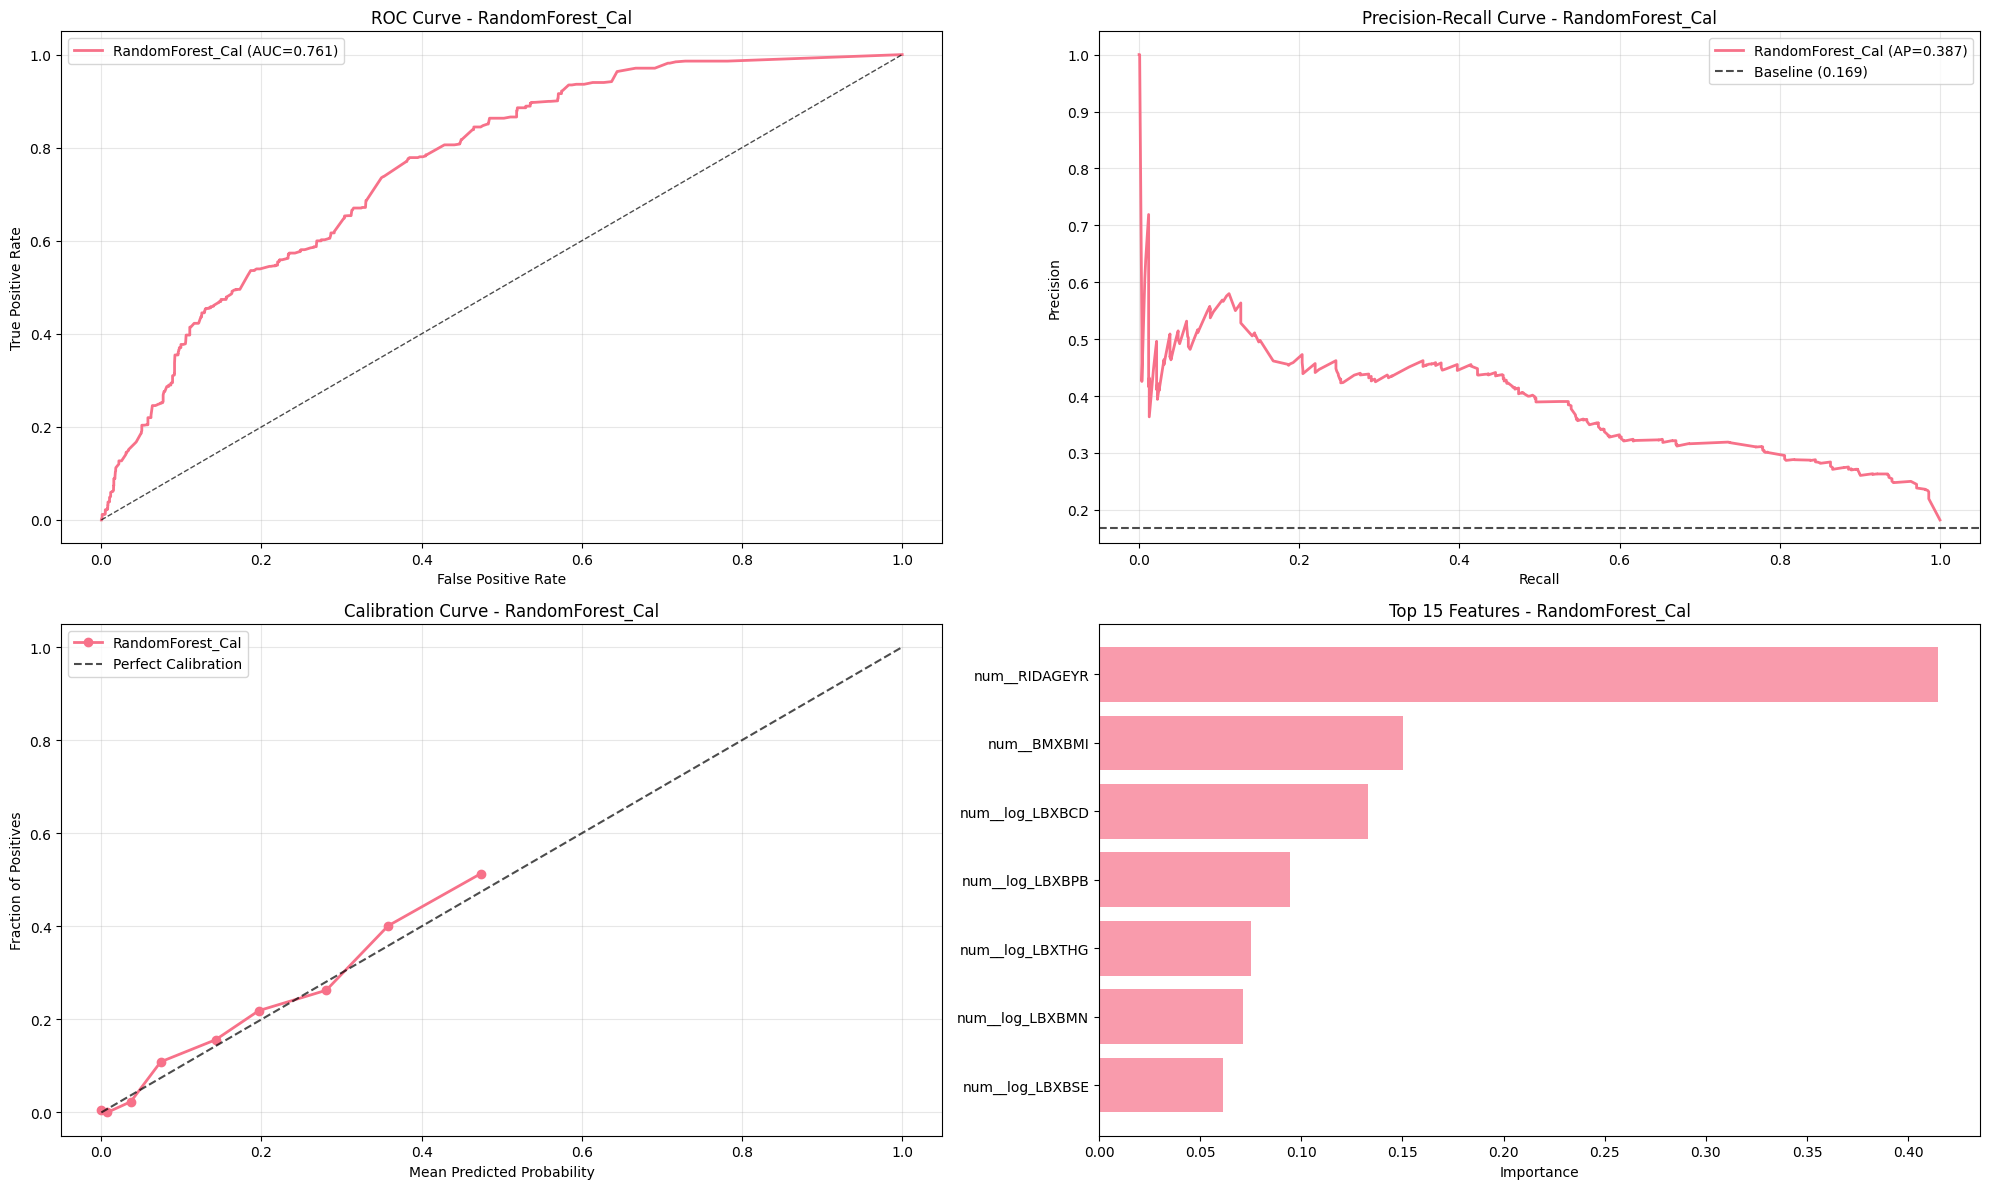

In [8]:
# Comprehensive Visualizations for RandomForest_Cal only

plt.style.use('default')
sns.set_palette("husl")
fig = plt.figure(figsize=(20, 12))

# ROC Curve
ax1 = plt.subplot(2, 2, 1)
fpr, tpr, _ = roc_curve(y_test, predictions["RandomForest_Cal"], sample_weight=w_test)
auc_score = weighted_auc(y_test, predictions["RandomForest_Cal"], sample_weight=w_test)
plt.plot(fpr, tpr, linewidth=2, label=f'RandomForest_Cal (AUC={auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForest_Cal')
plt.legend()
plt.grid(True, alpha=0.3)

# Precision-Recall Curve
ax2 = plt.subplot(2, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, predictions["RandomForest_Cal"], sample_weight=w_test)
ap_score = average_precision_score(y_test, predictions["RandomForest_Cal"], sample_weight=w_test)
plt.plot(recall, precision, linewidth=2, label=f'RandomForest_Cal (AP={ap_score:.3f})')
baseline = np.sum(y_test) / len(y_test)
plt.axhline(y=baseline, color='k', linestyle='--', alpha=0.7, label=f'Baseline ({baseline:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - RandomForest_Cal')
plt.legend()
plt.grid(True, alpha=0.3)

# Calibration Curve
ax3 = plt.subplot(2, 2, 3)
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, predictions["RandomForest_Cal"], n_bins=10, strategy='quantile'
)
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linewidth=2, label='RandomForest_Cal')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve - RandomForest_Cal')
plt.legend()
plt.grid(True, alpha=0.3)

# Feature Importance
ax4 = plt.subplot(2, 2, 4)
try:
    rf_cal_model = models["RandomForest_Cal"]
    classifier = rf_cal_model.calibrated_classifiers_[0].estimator.named_steps['classifier']
    if hasattr(classifier, 'feature_importances_') and feature_names is not None:
        importances = classifier.feature_importances_
        top_feats_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False).head(15)

        plt.barh(range(len(top_feats_df)), top_feats_df['Importance'], alpha=0.7)
        plt.yticks(range(len(top_feats_df)), top_feats_df['Feature'])
        plt.xlabel('Importance')
        plt.title('Top 15 Features - RandomForest_Cal')
        plt.gca().invert_yaxis()
    else:
        plt.text(0.5, 0.5, 'Feature importances not available',
                 ha='center', va='center', transform=plt.gca().transAxes)
except Exception as e:
    plt.text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()



 RandomForest_Cal - Feature Importance:
Top 15 features by importance:


Feature  Importance
5    num__RIDAGEYR    0.414766
6      num__BMXBMI    0.150358
1  num__log_LBXBCD    0.133076
0  num__log_LBXBPB    0.094173
2  num__log_LBXTHG    0.075140
4  num__log_LBXBMN    0.071260
3  num__log_LBXBSE    0.061227

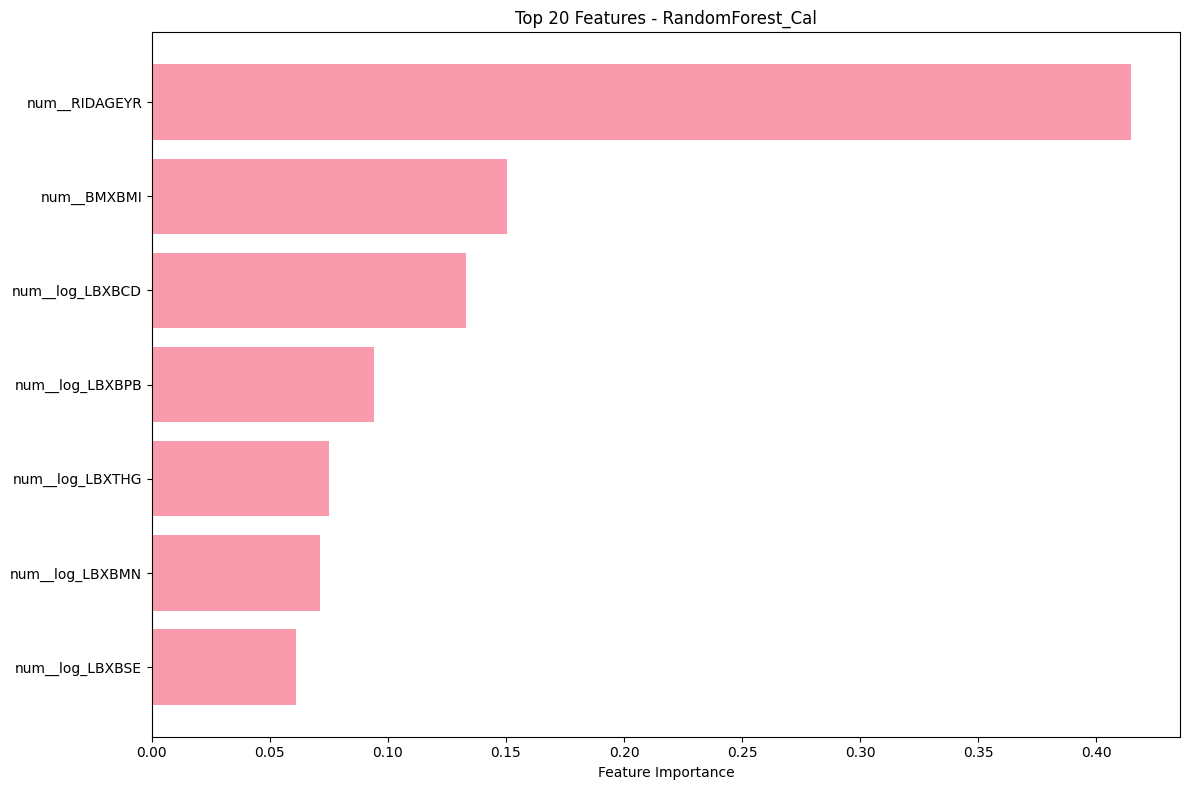

In [9]:
# Detailed Feature Importance Analysis for RandomForest_Cal

print("\n RandomForest_Cal - Feature Importance:")

try:
    # Access the calibrated RF model and extract underlying classifier
    rf_cal_model = models["RandomForest_Cal"]
    classifier = rf_cal_model.calibrated_classifiers_[0].estimator.named_steps['classifier']

    # Ensure feature importances exist
    if hasattr(classifier, 'feature_importances_') and feature_names is not None:
        rf_cal_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': classifier.feature_importances_
        }).sort_values('Importance', ascending=False)

        # Display top features
        print("Top 15 features by importance:")
        display(rf_cal_importance_df.head(15))

        # Plot top 20 feature importances
        plt.figure(figsize=(12, 8))
        top_rf_cal_features = rf_cal_importance_df.head(20)
        plt.barh(range(len(top_rf_cal_features)), top_rf_cal_features['Importance'], alpha=0.7)
        plt.yticks(range(len(top_rf_cal_features)), top_rf_cal_features['Feature'])
        plt.xlabel('Feature Importance')
        plt.title('Top 20 Features - RandomForest_Cal')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    else:
        print("  Feature importances or feature names not available.")

except Exception as e:
    print(f"  Error in RandomForest_Cal feature importance analysis: {e}")


In [12]:
# Export Results for RandomForest_Cal Only

# Create output directory
ensure_dir(CONFIG["outdir"])
print(f" Output directory: {CONFIG['outdir']}")

# --- 1. Export model performance summary ---
performance_file = os.path.join(CONFIG["outdir"], "model_performance_randomforest_cal.csv")
performance_df.to_csv(performance_file, index=False)
print(f" ✓ Saved model performance summary to {performance_file}")

# --- 2. Export ROC curve data ---
best_pred = predictions["RandomForest_Cal"]
fpr, tpr, thresholds = roc_curve(y_test, best_pred, sample_weight=w_test)
roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'threshold': thresholds
})
roc_file = os.path.join(CONFIG["outdir"], "roc_curve_RandomForest_Cal.csv")
roc_df.to_csv(roc_file, index=False)
print(f" ✓ Saved ROC curve data to {roc_file}")

# --- 3. Export Precision-Recall curve data ---
precision, recall, pr_thresholds = precision_recall_curve(y_test, best_pred, sample_weight=w_test)
pr_df = pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'threshold': np.append(pr_thresholds, 1)
})
pr_file = os.path.join(CONFIG["outdir"], "precision_recall_RandomForest_Cal.csv")
pr_df.to_csv(pr_file, index=False)
print(f" ✓ Saved Precision-Recall data to {pr_file}")

# --- 4. Export Calibration curve data ---
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, best_pred, n_bins=10, strategy='quantile'
)
num_bins = len(mean_predicted_value)
cal_df = pd.DataFrame({
    'bin_number': range(1, num_bins + 1),
    'mean_predicted_probability': mean_predicted_value,
    'observed_fraction': fraction_of_positives
})
cal_file = os.path.join(CONFIG["outdir"], "calibration_data_RandomForest_Cal.csv")
cal_df.to_csv(cal_file, index=False)
print(f" ✓ Saved Calibration curve data to {cal_file}")

# --- 5. Export Feature Importance ---
try:
    rf_cal_model = models["RandomForest_Cal"]
    classifier = rf_cal_model.calibrated_classifiers_[0].estimator.named_steps['classifier']

    if hasattr(classifier, 'feature_importances_') and feature_names is not None:
        rf_cal_imp_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': classifier.feature_importances_
        }).sort_values('Importance', ascending=False)

        rf_cal_file = os.path.join(CONFIG["outdir"], "random_forest_cal_importance.csv")
        rf_cal_imp_df.to_csv(rf_cal_file, index=False)
        print(f" ✓ Saved RandomForest_Cal feature importances to {rf_cal_file}")
    else:
        print(" ⚠ Feature importances or feature names not available.")
except Exception as e:
    print(f"  Could not save RandomForest_Cal importance: {e}")

# --- 6. Export Predictions ---
predictions_df = pd.DataFrame({
    'RandomForest_Cal': predictions["RandomForest_Cal"],
    'y_true': y_test
})
if w_test is not None:
    predictions_df['sample_weight'] = w_test

pred_file = os.path.join(CONFIG["outdir"], "predictions_RandomForest_Cal.csv")
predictions_df.to_csv(pred_file, index=False)
print(f" ✓ Saved predictions to {pred_file}")

# --- 7. Export Quartile Analysis (if metals exist) ---
if metal_cols:
    metal_for_export = metal_cols[0]
    quartile_col = f"q_{metal_for_export}"

    if quartile_col in modeling_df.columns:
        try:
            test_indices = X_test.index
            quartile_analysis = []
            for q in [1, 2, 3, 4]:
                mask = modeling_df.loc[test_indices, quartile_col] == q
                if mask.sum() > 0:
                    test_mask_array = mask.values
                    if w_test is not None:
                        mean_prob = np.average(best_pred[test_mask_array], weights=w_test[test_mask_array])
                        weighted_count = w_test[test_mask_array].sum()
                    else:
                        mean_prob = np.mean(best_pred[test_mask_array])
                        weighted_count = test_mask_array.sum()

                    quartile_analysis.append({
                        'Metal': metal_for_export,
                        'Quartile': int(q),
                        'N_Observations': test_mask_array.sum(),
                        'Weighted_N': weighted_count if w_test is not None else test_mask_array.sum(),
                        'Mean_Predicted_Probability': mean_prob,
                        'Mean_Predicted_Percentage': mean_prob * 100
                    })

            if quartile_analysis:
                quartile_df = pd.DataFrame(quartile_analysis)
                quartile_file = os.path.join(CONFIG["outdir"], f"quartile_analysis_{metal_for_export}_RandomForest_Cal.csv")
                quartile_df.to_csv(quartile_file, index=False)
                print(f" ✓ Saved quartile analysis to {quartile_file}")
        except Exception as e:
            print(f"  Could not save quartile analysis: {e}")

# --- 8. Export Summary Statistics ---
summary_stats = {
    'Analysis_Date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'Total_Observations': len(work_df),
    'Modeling_Observations': len(modeling_df),
    'Training_Observations': len(X_train),
    'Test_Observations': len(X_test),
    'Best_Model': "RandomForest_Cal",
    'Best_Model_AUC': best_auc,
    'Number_Features': len(feature_cols),
    'Survey_Weights_Used': weight_col if weight_col else 'None'
}
summary_df = pd.DataFrame([summary_stats])
summary_file = os.path.join(CONFIG["outdir"], "analysis_summary_RandomForest_Cal.csv")
summary_df.to_csv(summary_file, index=False)
print(f" ✓ Saved summary statistics to {summary_file}")

# --- 9. Create README file ---
readme_content = f"""# NHANES Heavy Metals & Disability Analysis Results (RandomForest_Cal)

## Overview
- **Date**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
- **Model**: RandomForest_Cal (Calibrated Random Forest)
- **AUC**: {best_auc:.4f}
- **Dataset**: NHANES 2011–2016 cycles G, H, I
- **Outcome**: {CONFIG['columns']['outcome']}
- **Total Observations**: {len(work_df):,}
- **Modeling Sample**: {len(modeling_df):,}

## Exported Files
- `model_performance_randomforest_cal.csv`
- `roc_curve_RandomForest_Cal.csv`
- `precision_recall_RandomForest_Cal.csv`
- `calibration_data_RandomForest_Cal.csv`
- `random_forest_cal_importance.csv`
- `predictions_RandomForest_Cal.csv`
- `analysis_summary_RandomForest_Cal.csv`

Generated by NHANES Heavy Metals & Disability Pipeline
"""

readme_file = os.path.join(CONFIG["outdir"], "README_RandomForest_Cal.md")
with open(readme_file, 'w') as f:
    f.write(readme_content)

print(f" ✓ Created README file: {readme_file}")


 Output directory: results_comprehensive
 ✓ Saved model performance summary to results_comprehensive/model_performance_randomforest_cal.csv
 ✓ Saved ROC curve data to results_comprehensive/roc_curve_RandomForest_Cal.csv
 ✓ Saved Precision-Recall data to results_comprehensive/precision_recall_RandomForest_Cal.csv
 ✓ Saved Calibration curve data to results_comprehensive/calibration_data_RandomForest_Cal.csv
 ✓ Saved RandomForest_Cal feature importances to results_comprehensive/random_forest_cal_importance.csv
 ✓ Saved predictions to results_comprehensive/predictions_RandomForest_Cal.csv
 ✓ Saved quartile analysis to results_comprehensive/quartile_analysis_LBXBPB_RandomForest_Cal.csv
 ✓ Saved summary statistics to results_comprehensive/analysis_summary_RandomForest_Cal.csv
 ✓ Created README file: results_comprehensive/README_RandomForest_Cal.md
